In [1]:
import os
import numpy as np
import pandas as pd
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.utils.visualisation import plotFig
from TSB_UAD.models.damp import DAMP
from TSB_UAD.vus.metrics import get_metrics
from TSB_UAD.models.matrix_profile import MatrixProfile
from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.imondrian.mondrianforest import MondrianForest
from TSB_UAD.models.sand import SAND
from sklearn.preprocessing import MinMaxScaler
import math 
from TSB_UAD.vus import metrics

# Read data -- create/read a normality-2 dataset named `combined.csv`
# filepath = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_9.out"
ts1 = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_9.out"
ts2 = "data/TSB-UAD-Public/ECG/MBA_ECG14046_data_20.out"
# df = pd.read_csv(filepath, header=None).dropna().to_numpy()

filepath = 'MBA_ECG14046_data_9_20.csv'
name = filepath.split('/')[-1]
if not os.path.exists(filepath):
    df1 = pd.read_csv(ts1, header=None).dropna().to_numpy()
    df2 = pd.read_csv(ts2, header=None).dropna().to_numpy()
    combined = np.vstack((df1, df2))
    pd.DataFrame(combined).to_csv(filepath, header=False, index=False)

df = pd.read_csv(filepath, header=None).dropna().to_numpy()
data = df[:, 0].astype(float)
labels = df[:, 1].astype(int)


/home/lazaros/Documents/ΑΠΘ/msc/2ο εξαμηνο/MMDS/project/TSB-UAD/TSB_UAD/models/imondrian/mondrianforest.py:64: UserWarning: pydot not loaded: tree will not be printed; set draw_mondrian=0
  warn('pydot not loaded: tree will not be printed; set draw_mondrian=0')


In [2]:
# Preprocessing
# slidingWindow = 10 # user defined

# or auto sliding window length
slidingWindow = find_length(data)
X_data = Window(window=slidingWindow).convert(data).to_numpy()

In [3]:
def evaluate(score, modelName, slidingWindow, name, predict=True):
    from TSB_UAD.vus import metrics
    from importlib import reload
    metrics = reload(metrics)
    # post processing
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    if predict:
        score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
    results = metrics.get_metrics(score, labels, metric="all", slidingWindow=slidingWindow)
    for metric in results.keys():
        print(metric, ":", results[metric])
    plotFig(data[:len(score)], labels[:len(score)], score, slidingWindow, fileName=name, modelName=modelName)

AUC_ROC : 0.7023001892000569
AUC_PR : 0.2545052255441522
Precision : 0.3596358118361153
Recall : 0.15598946906537955
F : 0.21759755164498853
Precision_at_k : 0.15598946906537955
Rprecision : 0.09783407985413715
Rrecall : 0.2808231296714516
RF : 0.14511316199465563
R_AUC_ROC : 0.7575088835059278
R_AUC_PR : 0.2564088261899298
VUS_ROC : 0.7839444146134043
VUS_PR : 0.2735130420884779
Affiliation_Precision : 0.6937712339291673
Affiliation_Recall : 0.9608436064129201


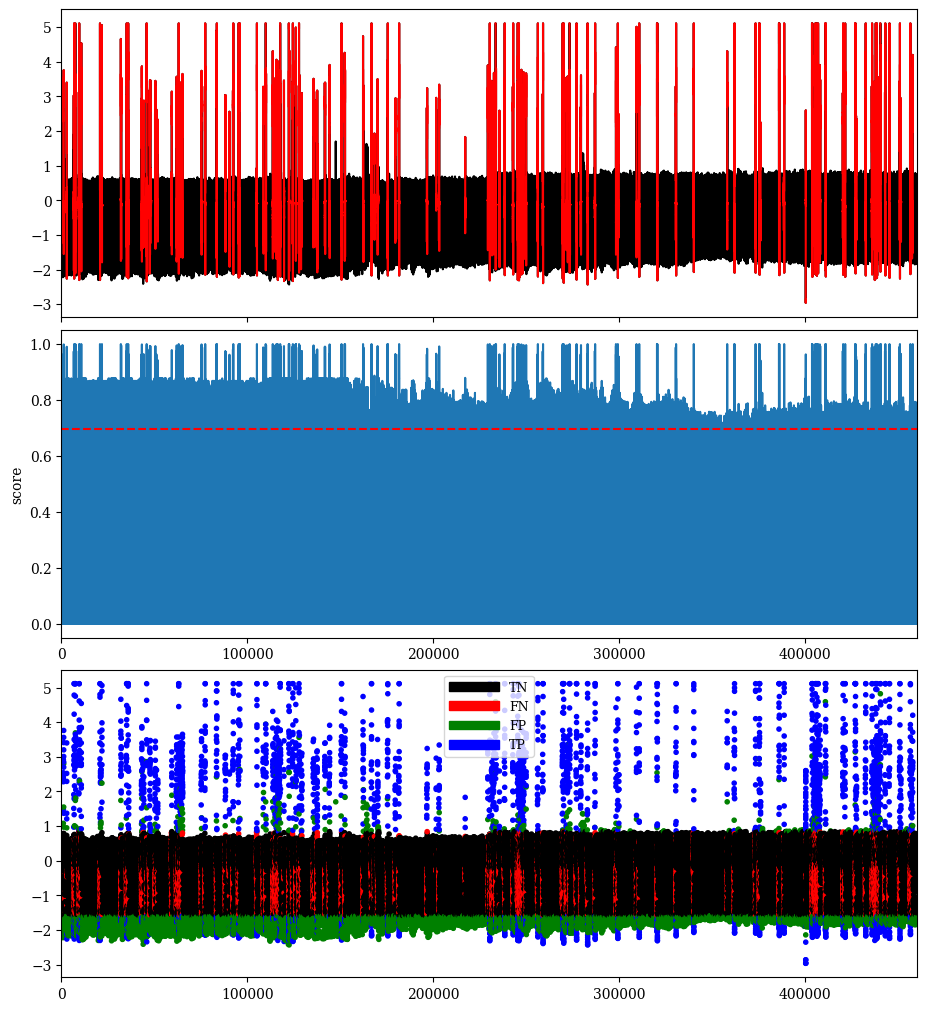

In [5]:
# Run offline Isolation Forest
modelName = 'IForest'
clf = IForest(n_jobs=1)
x = X_data
x = data
labels = labels
clf.fit(x)
score = clf.decision_scores_
# post processing
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
# if predict:
# score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
results = metrics.get_metrics(score, labels, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ":", results[metric])
plotFig(data[:len(score)], labels[:len(score)], score, slidingWindow, fileName=name, modelName=modelName)

Training on 459800 samples of dimension 1
0-->5000-->10000-->15000-->20000-->25000-->30000-->35000-->40000-->45000-->50000-->55000-->60000-->65000-->70000-->75000-->80000-->85000-->90000-->95000-->100000-->105000-->110000-->115000-->120000-->125000-->130000-->135000-->140000-->145000-->150000-->155000-->160000-->165000-->170000-->175000-->180000-->185000-->190000-->195000-->200000-->205000-->210000-->215000-->220000-->225000-->230000-->235000-->240000-->245000-->250000-->255000-->260000-->265000-->270000-->275000-->280000-->285000-->290000-->295000-->300000-->305000-->310000-->315000-->320000-->325000-->330000-->335000-->340000-->345000-->350000-->355000-->360000-->365000-->370000-->375000-->380000-->385000-->390000-->395000-->400000-->405000-->410000-->415000-->420000-->425000-->430000-->435000-->440000-->445000-->450000-->455000-->459800 [END]
AUC_ROC : 0.6977705748924349
AUC_PR : 0.2750981157882265
Precision : 0.4874668239457387
Recall : 0.1450636243966652
F : 0.22358988232111454
Pr

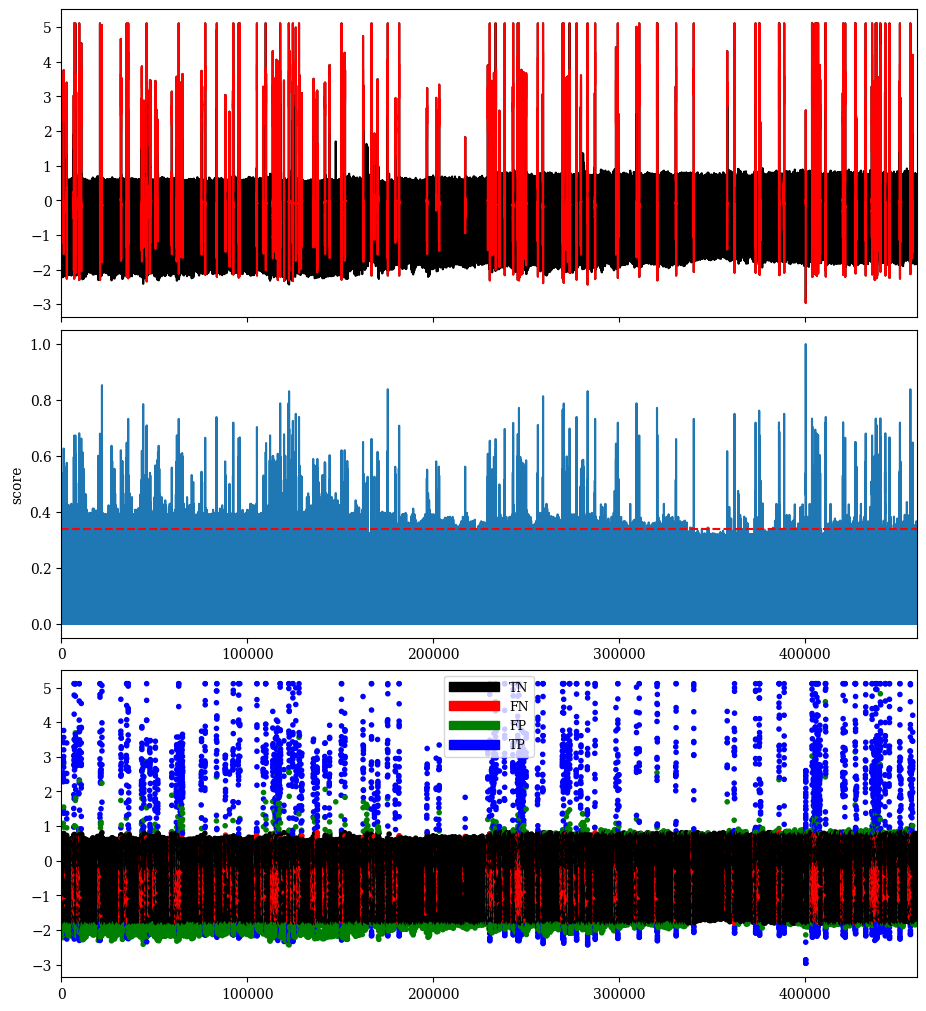

In [6]:
# Run online Isolation Forest (variant 2)
# %load_ext autoreload
%matplotlib inline
modelName = 'IForest (online variant 2)'
# import warnings
# warnings.filterwarnings('ignore') # this will make warm_start produce no warnings :)
clf = IForest(n_jobs=1)
data = data
labels = labels
clf.fit(X=data, y=labels, online=True, verbose=True, batch_size=5_000, variant=2)
score = clf.decision_scores_

# post processing
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
# if predict:
#     score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
results = metrics.get_metrics(score, labels, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ":", results[metric])
plotFig(data[:len(score)], labels[:len(score)], score, slidingWindow, fileName=name, modelName=modelName)

In [ ]:
from statsmodels.tsa.stattools import acf
from scipy.signal import argrelextrema
import numpy as np

import matplotlib.patches as mpatches 
import matplotlib.pyplot as plt

from TSB_UAD.vus.utils.metrics import metricor

def _plotFig(data, label, score, plotRange=None):
    grader = metricor()
    
    range_anomaly = grader.range_convers_new(label)
    
    max_length = len(score)

    if plotRange==None:
        plotRange = [0,max_length]
    
    fig3 = plt.figure(figsize=(12, 10), constrained_layout=True)
    gs = fig3.add_gridspec(3, 4)
    
    
    f3_ax1 = fig3.add_subplot(gs[0, :-1]) # FIXME
    plt.tick_params(labelbottom=False)

    plt.plot(data[:max_length],'k')
    for r in range_anomaly:
        if r[0]==r[1]:
            plt.plot(r[0],data[r[0]],'r.')
        else:
            plt.plot(range(r[0],r[1]+1),data[range(r[0],r[1]+1)],'r')
    
    plt.xlim(plotRange)
    

    f3_ax2 = fig3.add_subplot(gs[1, :-1])
    
    plt.plot(score[:max_length])
    plt.hlines(np.mean(score)+3*np.std(score),0,max_length,linestyles='--',color='red')
    plt.ylabel('score')
    
    plt.xlim(plotRange)
    
    
    #plot the data
    f3_ax3 = fig3.add_subplot(gs[2, :-1])
    index = ( label + 2*(score > (np.mean(score)+3*np.std(score))))
    cf = lambda x: 'k' if x==0 else ('r' if x == 1 else ('g' if x == 2 else 'b') )
    cf = np.vectorize(cf)
    
    color = cf(index[:max_length])
    black_patch = mpatches.Patch(color = 'black', label = 'TN')
    red_patch = mpatches.Patch(color = 'red', label = 'FN')
    green_patch = mpatches.Patch(color = 'green', label = 'FP')
    blue_patch = mpatches.Patch(color = 'blue', label = 'TP')
    plt.scatter(np.arange(max_length), data[:max_length], c=color, marker='.')
    plt.legend(handles = [black_patch, red_patch, green_patch, blue_patch], loc= 'best')
    plt.xlim(plotRange)
    
_plotFig(data[:len(score)], labels[:len(score)], score, )

GridSpec(3, 4)
Error in callback <function _draw_all_if_interactive at 0x7f0c23446a60> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmphkx25fvs d174ba5a1278c3ea3324ab2ddb79f45c.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./d174ba5a1278c3ea3324ab2ddb79f45c.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmphkx25fvs/d174ba5a1278c3ea3324ab2ddb79f45c.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpb4sbsh83 d174ba5a1278c3ea3324ab2ddb79f45c.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./d174ba5a1278c3ea3324ab2ddb79f45c.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmpb4sbsh83/d174ba5a1278c3ea3324ab2ddb79f45c.log.




<Figure size 1200x1000 with 3 Axes>

Error in callback <function _draw_all_if_interactive at 0x7f0c23446a60> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp6o_w86zc d174ba5a1278c3ea3324ab2ddb79f45c.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./d174ba5a1278c3ea3324ab2ddb79f45c.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp6o_w86zc/d174ba5a1278c3ea3324ab2ddb79f45c.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpgtzwo3ad d174ba5a1278c3ea3324ab2ddb79f45c.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./d174ba5a1278c3ea3324ab2ddb79f45c.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmpgtzwo3ad/d174ba5a1278c3ea3324ab2ddb79f45c.log.




<Figure size 1200x1000 with 3 Axes>